In [1]:
import pandas as pd
import numpy as np
import warnings
import plotly.express as px 
warnings.filterwarnings('ignore')

movies = pd.read_csv("movies_metadata.csv")

Подготовка данных
=================

In [2]:
movies.sample(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
21814,False,NaN,0,[],NaN,128917,tt0100888,en,Voodoo Dawn,Group of immigrant Haitian farm workers tries ...,...,1991-01-24,0.0,84.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Rumored,NaN,Voodoo Dawn,False,2.3,3.0
41142,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,415214,tt6044910,zh,Mei Gong He Xing Dong,Chinese narco-cops take their mission to the G...,...,2016-09-30,173000000.0,140.0,"[{'iso_639_1': 'my', 'name': ''}, {'iso_639_1'...",Released,NaN,Operation Mekong,False,6.8,30.0
40160,False,"{'id': 444275, 'name': 'Eccezzziunale... veram...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,38289,tt0083871,it,Eccezzziunale... veramente,NaN,...,1982-01-01,0.0,98.0,[],Released,NaN,Eccezzziunale... veramente,False,5.9,41.0


In [3]:
movies.drop(['homepage', 'imdb_id', 'original_title', 'overview', 'tagline', 'video'], axis=1);

В базе данных выстречаются "мусорные" значения

In [4]:
movies[movies['budget'].apply(lambda m : not str(m).isnumeric())]['budget']

19730    /ff9qCepilowshEtG2GYWwzt2bs4.jpg
29503    /zV8bHuSL6WXoD6FWogP9j4x80bL.jpg
35587    /zaSf5OG7V8X8gqFvly88zDdRm46.jpg
Name: budget, dtype: object

Отредактируем её для дальнейшего анализа

In [5]:
movies['budget'] = pd.to_numeric(movies['budget'], errors='coerce')
movies['budget'] = movies['budget'].replace(0, np.nan)
movies['revenue'] = movies['revenue'].replace(0, np.nan)
movies['title'] = movies['title'].astype('str')

Для удобства добавим в базу данных год выхода каждого фильма и заработанную им чистую прибыль.

In [6]:
movies['netprofit'] = movies['revenue'] - movies['budget']
movies['year'] = pd.to_datetime(movies['release_date'], errors='coerce').apply(lambda date:
str(date).split('-')[0] if date != np.nan else np.nan)

Самые старые фильмы:

In [7]:
print(movies.sort_values(by=['year'])[['title', 'year']].head(5))

                               title  year
34940               Passage of Venus  1874
34937     Sallie Gardner at a Gallop  1878
41602                Buffalo Running  1883
34933    Man Walking Around a Corner  1887
34938  Traffic Crossing Leeds Bridge  1888


Посмотрим какие слова используются в названиях фильмов
-------------------------------------------------------------------------------------------

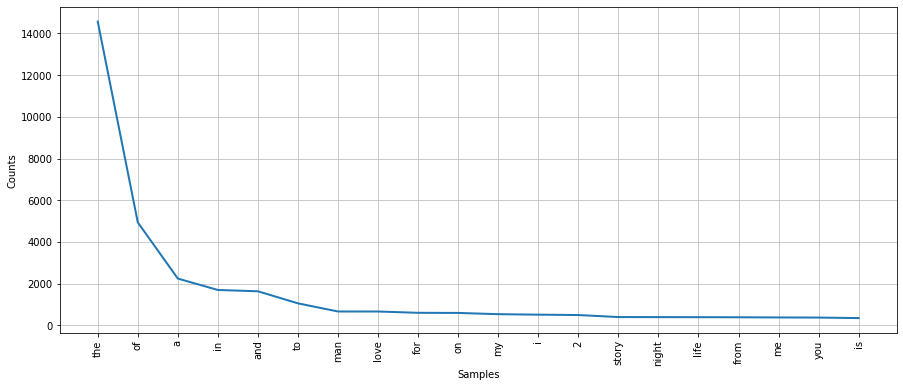

In [25]:
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
import string
text = ' '.join(movies['title'])
text = text.lower()
text = "".join([ch for ch in text if ch not in string.punctuation])
text_tokens = word_tokenize(text)
text = nltk.Text(text_tokens)
fdist = FreqDist(text)
plt.figure(figsize = (15, 6))
fdist.plot(20, cumulative=False)
plt.show()

Ожидаемо, наиболее часто встречаются предлоги, артикли и другие слова не несущие смысловой нагрузки. Удалим эти "шумы".

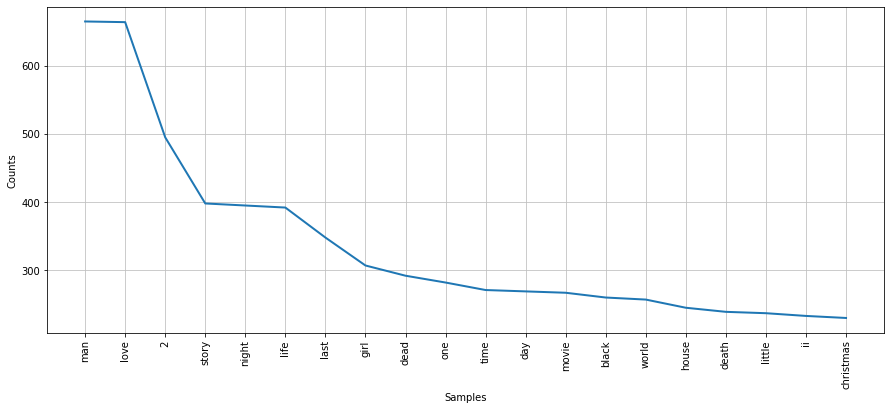

In [9]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
text_tokens = [word for word in text_tokens if word not in stop_words]
text = nltk.Text(text_tokens)
fdist = FreqDist(text)
plt.figure(figsize = (15, 6))
fdist.plot(20, cumulative=False)
plt.show()

Проанализириуем продолжительность и оценки фильмов
---------------------------------------------------------------------------------------

In [10]:
import seaborn as sbn
import scipy.stats as stats
def to_float(x):
    try:
        return float(x)
    except:
        return np.nan
movies['runtime'] = movies['runtime'].astype('float')
movies['vote_average'] = movies['vote_average'].apply(to_float).astype('float')
movies['vote_average'] = movies['vote_average'].replace(0.0, np.nan)
movies['vote_count'] = movies['revenue'].apply(to_float).astype('float')
movies['vote_count'] = movies['vote_count'].replace(0.0, np.nan)

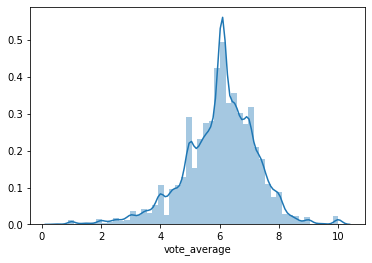

In [11]:
sbn.distplot(movies['vote_average'].fillna(movies['vote_average'].median()))

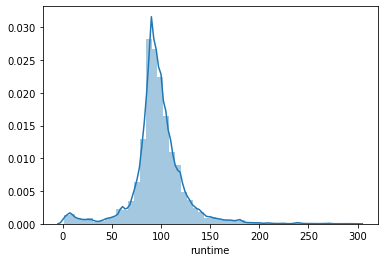

In [12]:
sbn.distplot(movies[(movies['runtime'] < 300) & (movies['runtime'] > 0)]['runtime'])

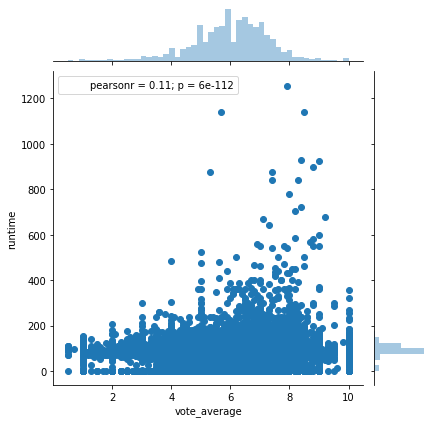

In [13]:
plot = sbn.jointplot(x='vote_average', y='runtime', data=movies)
plot.annotate(stats.pearsonr)
plt.show()

Коэффициент корреляции пирсона равен 0.11, что свидетельствует о слабой связи между оценкой фильма и его продолжительностью.

Оценка и продолжительность ста самых популярных фильмом:
-----------------------------------------------------------------------------------------------

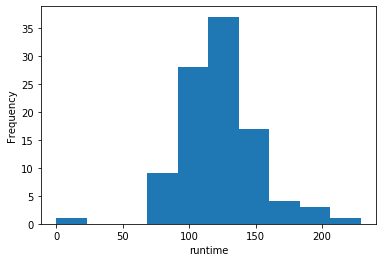

In [14]:
movies['popularity'] = movies['popularity'].apply(to_float).astype('float')
movies.sort_values('popularity', ascending=False)['runtime'].head(100).plot(kind='hist')
plt.xlabel('runtime')
plt.show()

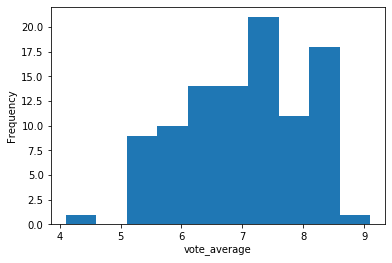

In [15]:
movies.sort_values('popularity', ascending=False)['vote_average'].head(100).plot(kind='hist')
plt.xlabel('vote_average')
plt.show()

Как менялись средняя продолжительность и оценка фильмов с течением времени?
------------------------------------------------------------------------------------------------------------------------------

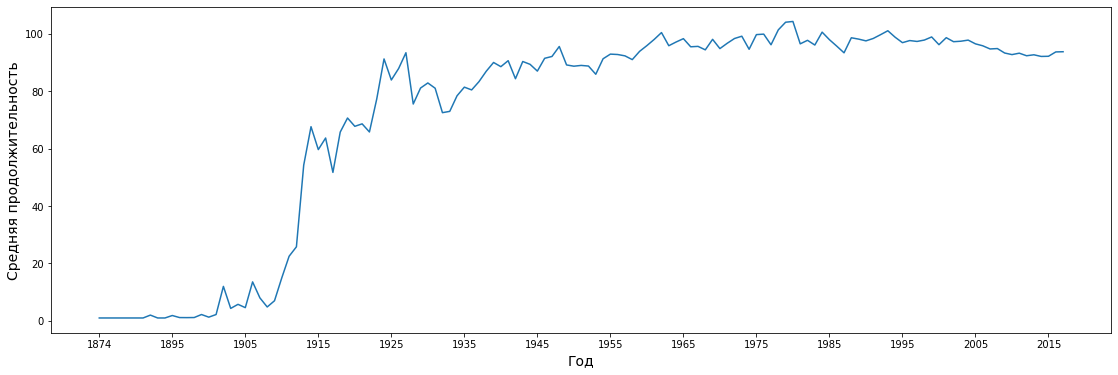

In [16]:
plt.figure(figsize=(19,6))
year_runtime = movies[movies['year'] != 'NaT'].groupby(['year'])['runtime'].mean()
ax = plt.subplot(1, 1, 1)
ax.plot(year_runtime.index[:-2], year_runtime[:-2])
xticks = ax.get_xticks()
ax.set_xticks(xticks[::10])
ax.set_xlabel('Год', fontsize=14)
ax.set_ylabel('Средняя продолжительность', fontsize=14)
plt.show()

В 1910-х средняя продолжительность достигла 60 минут. Затем, увеличившись в 1920-х до 90 минут, она больше значительно не изменялась.

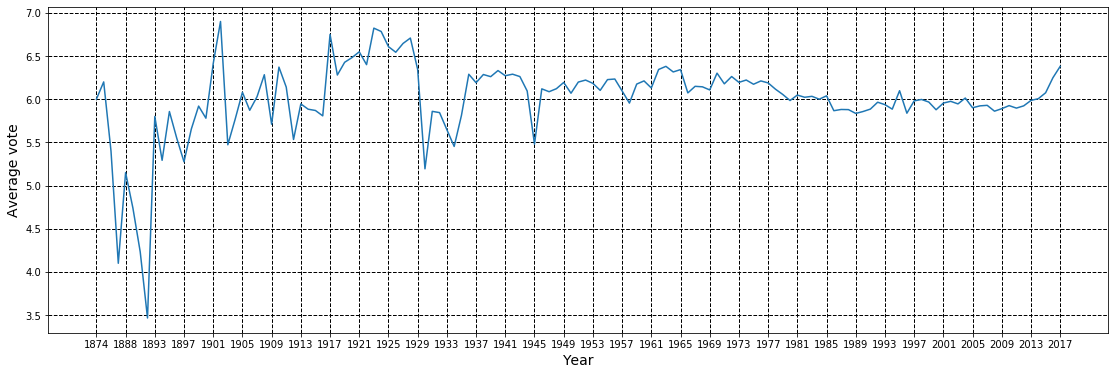

In [17]:
plt.figure(figsize=(19,6))
year_vote = movies[movies['year'] != 'NaT'].groupby(['year'])['vote_average'].mean()
ax = plt.subplot(1, 1, 1)
ax.plot(year_vote.index[:-2], year_vote[:-2])
xticks = ax.get_xticks()
ax.set_xticks(xticks[::4])
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Average vote', fontsize=14)
plt.grid(color='black', linestyle='--', linewidth=1)
plt.show()

Выходит, что 1917-1927 - золотое десятилетие кино? Скорее дело в малом количестве оценок фильмов этих лет. 

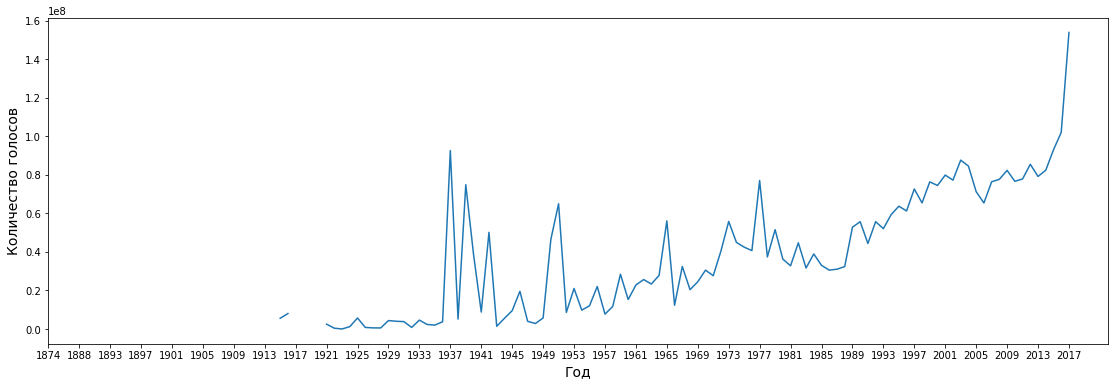

In [18]:
plt.figure(figsize=(19,6))
year_vote = movies[movies['year'] != 'NaT'].groupby(['year'])['vote_count'].mean()
ax = plt.subplot(1, 1, 1)
ax.plot(year_vote.index[:-2], year_vote[:-2])
xticks = ax.get_xticks()
ax.set_xticks(xticks[::4])
ax.set_xlabel('Год', fontsize=14)
ax.set_ylabel('Количество голосов', fontsize=14)
plt.show()

Теперь рассмотрим финансовые показатели картин
=============================================

Наиболее и наименее успешные фильмы
--------------------------------------------------------------

In [19]:
movies[['title', 'budget', 'netprofit', 'year']].sort_values('netprofit', ascending=False).head(10)

,title,budget,netprofit,year
14551,Avatar,237000000.0,2.550965e+09,2009
26555,Star Wars: The Force Awakens,245000000.0,1.823224e+09,2015
1639,Titanic,200000000.0,1.645034e+09,1997
25084,Jurassic World,150000000.0,1.363529e+09,2015
28830,Furious 7,190000000.0,1.316249e+09,2015
17818,The Avengers,220000000.0,1.299558e+09,2012
17437,Harry Potter and the Deathly Hallows: Part 2,125000000.0,1.217000e+09,2011
26558,Avengers: Age of Ultron,280000000.0,1.125404e+09,2015
22110,Frozen,150000000.0,1.124219e+09,2013
42222,Beauty and the Beast,160000000.0,1.102886e+09,2017


In [20]:
movies[['title', 'budget', 'netprofit', 'year']].sort_values('netprofit').head(10)

,title,budget,netprofit,year
21175,The Lone Ranger,255000000.0,-165710090.0,2013
7226,The Alamo,145000000.0,-119180039.0,2004
16788,Mars Needs Moms,150000000.0,-111007242.0,2011
44337,Valerian and the City of a Thousand Planets,197471676.0,-107447384.0,2017
2711,The 13th Warrior,160000000.0,-98301101.0,1999
5389,The Adventures of Pluto Nash,100000000.0,-92896027.0,2002
1901,Metropolis,92620000.0,-91969578.0,1927
14,Cutthroat Island,98000000.0,-87982678.0,1995
41491,Live by Night,108000000.0,-85321445.0,2016
11376,Flushed Away,149000000.0,-84540684.0,2006


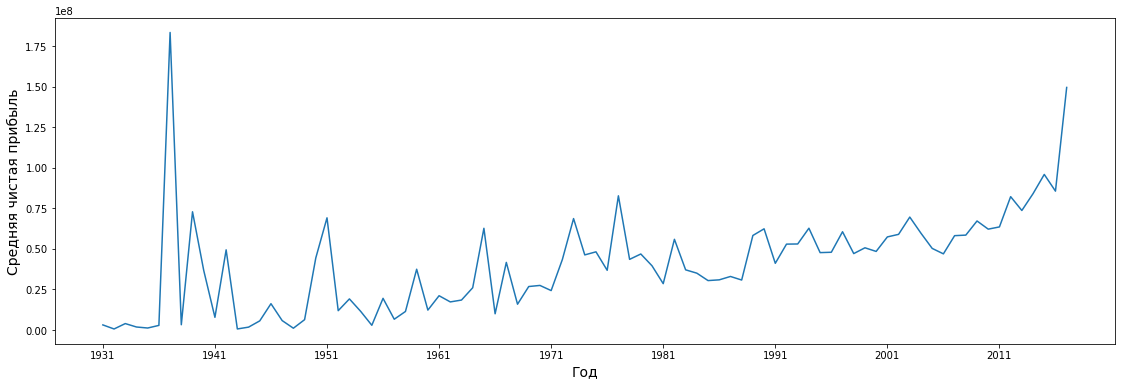

In [21]:
plt.figure(figsize=(19,6))
year_netprofit = movies[pd.to_numeric(movies['year'], errors='coerce') > 1930].groupby('year')['netprofit']
year_netprofit = year_netprofit.mean()
ax = plt.subplot(1, 1, 1)
ax.plot(year_netprofit.index[:-2], year_netprofit[:-2])
xticks = ax.get_xticks()
ax.set_xticks(xticks[::10])
ax.set_xlabel('Год', fontsize=14)
ax.set_ylabel('Средняя чистая прибыль', fontsize=14)
plt.show()

Судя по графику, фильмы заработали наибольшую среднюю чистую прибыль в один из годов 1930-х, и вообще этот показатель рос достаточно медленно. Но скорее всего в базе данных просто недопредставлены провальные фильмы старых годов. Рассмотрим среднюю чистую прибыль для 10 самых успешных фильмов каждого года. 

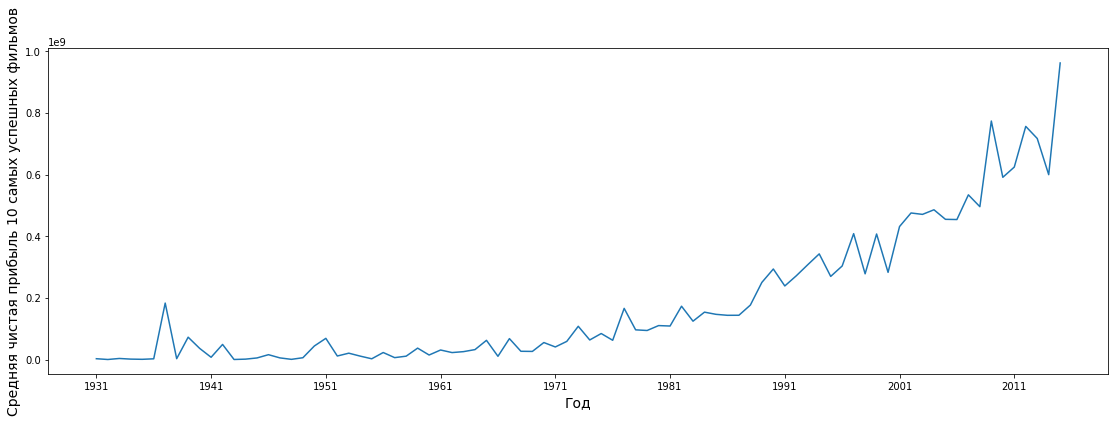

In [22]:
year_netprofit = movies[pd.to_numeric(movies['year'], errors='coerce') > 1930].groupby(['year'])
year_netprofit = year_netprofit['netprofit'].nlargest(10).mean(level=0)
plt.figure(figsize=(19,6))
ax = plt.subplot(1, 1, 1)
ax.plot(year_netprofit.index[:-2], year_netprofit[:-2])
xticks = ax.get_xticks()
ax.set_xticks(xticks[::10])
ax.set_xlabel('Год', fontsize=14)
ax.set_ylabel('Средняя чистая прибыль 10 самых успешных фильмов', fontsize=14)
plt.show()

Зависит ли прибыль картины от её бюджета?
--------------------------------------------------------------------

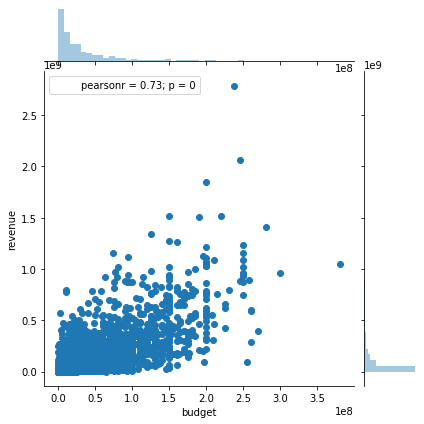

In [23]:
plot = sbn.jointplot(x='budget', y='revenue', data=movies[movies['netprofit'].notnull()])
plot.annotate(stats.pearsonr)
plt.show()

Коэффициент пирсона равен 0.73 - сильная корреляция. А что с чистой прибылью?

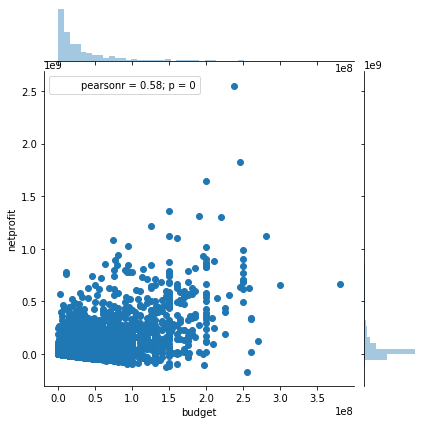

In [24]:
plot = sbn.jointplot(x='budget', y='netprofit', data=movies[movies['netprofit'].notnull()])
plot.annotate(stats.pearsonr)
plt.show()

0.58 - уже не так однозначно.